# Generating SDF Fields from MNIST and confirming validity

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt



In [2]:
# Load MNIST grayscale (no resize here)
mnist = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())

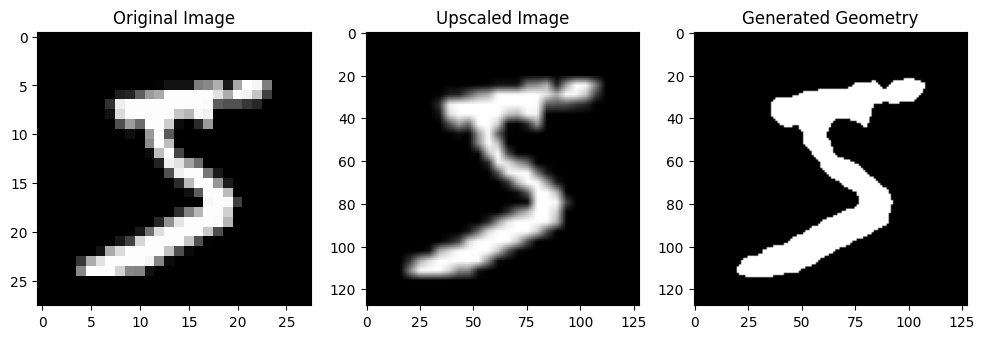

In [3]:
img28, label = mnist[0]                   # img28: [1,28,28] in [0,1]

# Resize FIRST (antialiased), then threshold
target_size = (128, 128)
resize = transforms.Resize(target_size, antialias=True)  # bilinear for PIL under the hood
img128 = resize(img28)                     # [1,128,128], still grayscale
# Threshold to create binary mask
threshold = 0.4
mask = (img128 >= threshold).float()       # binary mask [1,128,128]    


# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img28.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Upscaled Image")
plt.imshow(img128.squeeze(), cmap='gray')


plt.subplot(1, 3, 3)
plt.title("Generated Geometry")
plt.imshow(mask.squeeze(), cmap='gray')
plt.savefig("./figures/upscale_mnist.png", bbox_inches='tight', dpi=300)
plt.show()

# Calculating the SDF Field

In [4]:
mask = (mask.squeeze().detach().cpu().numpy()).astype(np.uint8)

# Distances: edt computes, for each ZERO pixel, distance to nearest NON-ZERO pixel
dist_outside = edt(mask == 0)  # distance for background pixels to the digit
dist_inside  = edt(mask == 1)  # distance for foreground pixels to the background

sdf = dist_outside - dist_inside          # NEGATIVE inside (mask==1), POSITIVE outside

# Optional: match MetaSDF scale (divide by image width) - sdf /= float(mask.shape[1])

# Solving PDEs

In [5]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

def coeff_from_sdf(
    sdf, a_in=10.0, a_out=1.0, smooth_alpha=None
):
    """
    Map SDF -> coefficient a(x).
    If smooth_alpha is None: binary jump (inside=phi<0).
    If smooth_alpha>0: smooth transition via sigmoid(smooth_alpha * -sdf).
    """
    sdf = np.asarray(sdf, dtype=np.float64)
    if smooth_alpha is None:
        inside = (sdf < 0).astype(np.float64)
    else:
        # sigmoid so inside (sdf<0) -> ~1, outside -> ~0
        inside = 1.0 / (1.0 + np.exp(smooth_alpha * sdf))
    return a_out + (a_in - a_out) * inside  # shape [H,W], positive everywhere

def build_rhs_f(H, W, kind="gaussian", strength=1.0, sigma_frac=0.06, centers=None):
    """
    Simple RHS choices for -div(a grad u) = f.
    - 'gaussian': one or two smooth bumps (default: one at center).
    - You can pass multiple centers in normalized coords [(cx, cy), ...].
    """
    yy, xx = np.linspace(0, 1, H), np.linspace(0, 1, W)
    Y, X = np.meshgrid(yy, xx, indexing='ij')
    f = np.zeros((H, W), dtype=np.float64)

    if centers is None:
        centers = [(0.5, 0.5)]  # center bump

    for (cx, cy) in centers:
        r2 = (X - cx)**2 + (Y - cy)**2
        sigma2 = (sigma_frac**2)
        f += strength * np.exp(-r2 / (2*sigma2)) / (2*np.pi*sigma2)

    return f


In [6]:
def solve_elliptic_conductivity(a, f, dirichlet_bc_value=0.0):
    """
    Solve: -div(a grad u) = f on the full HxW grid with Dirichlet u=const on outer boundary.
    Discretization: 5-point FD with **harmonic mean** face coefficients (stable across jumps).
    Returns u [H,W].
    """
    a = np.asarray(a, dtype=np.float64)
    f = np.asarray(f, dtype=np.float64)
    H, W = a.shape
    assert f.shape == (H, W)

    # Grid spacing (unit square)
    hx = 1.0 / (W - 1)
    hy = 1.0 / (H - 1)
    inv_hx2 = 1.0 / (hx*hx)
    inv_hy2 = 1.0 / (hy*hy)

    # Unknowns are interior nodes (1..H-2, 1..W-2)
    Ni, Nj = H-2, W-2
    N = Ni * Nj

    # Helpers to map (i,j) -> linear index k
    def idx(i, j):
        # i,j are interior indices in 1..H-2, 1..W-2
        return (i-1)*Nj + (j-1)

    A = sparse.lil_matrix((N, N), dtype=np.float64)
    b = np.zeros(N, dtype=np.float64)

    eps = 1e-12  # to avoid division by zero in harmonic mean

    for i in range(1, H-1):       # interior rows
        for j in range(1, W-1):   # interior cols
            k = idx(i, j)

            # Face coefficients via harmonic mean of neighboring cell 'a'
            aC = a[i, j]

            # East face (i, j+1/2)
            aE = 2.0 * aC * a[i, j+1] / (aC + a[i, j+1] + eps)
            # West face (i, j-1/2)
            aW = 2.0 * aC * a[i, j-1] / (aC + a[i, j-1] + eps)
            # North face (i+1/2, j)
            aN = 2.0 * aC * a[i+1, j] / (aC + a[i+1, j] + eps)
            # South face (i-1/2, j)
            aS = 2.0 * aC * a[i-1, j] / (aC + a[i-1, j] + eps)

            diag = (aE + aW) * inv_hx2 + (aN + aS) * inv_hy2

            # Center
            A[k, k] = diag

            # West neighbor (j-1): if interior, add off-diagonal; boundary is Dirichlet 0 so contributes nothing to b
            if j-1 >= 1:
                A[k, idx(i, j-1)] = -aW * inv_hx2
            # East neighbor
            if j+1 <= W-2:
                A[k, idx(i, j+1)] = -aE * inv_hx2
            # South neighbor (i-1)
            if i-1 >= 1:
                A[k, idx(i-1, j)] = -aS * inv_hy2
            # North neighbor (i+1)
            if i+1 <= H-2:
                A[k, idx(i+1, j)] = -aN * inv_hy2

            # RHS
            b[k] = f[i, j]

            # If you want non-zero Dirichlet BC on outer box, add contributions to b here:
            # For example, west boundary neighbor (j=1 has left neighbor at j=0 with u=bc):
            # if j == 1: b[k] += aW * inv_hx2 * dirichlet_bc_value
            # Similarly for j==W-2 (east), i==1 (south), i==H-2 (north).
            # For u=0 (default), no change is needed.

    # Solve
    A = A.tocsr()
    u_int = spsolve(A, b)  # SPD; for very large grids you can use CG

    # Reassemble full field, set boundary to Dirichlet value
    u = np.full((H, W), float(dirichlet_bc_value), dtype=np.float64)
    u[1:-1, 1:-1] = u_int.reshape(Ni, Nj)
    return u


In [7]:
def velocity_from_u(u, a):
    """
    Darcy velocity v = -a * grad(u). Central differences for interior.
    Returns vx, vy of shape [H,W].
    """
    u = np.asarray(u, dtype=np.float64)
    a = np.asarray(a, dtype=np.float64)
    H, W = u.shape
    hx = 1.0 / (W - 1)
    hy = 1.0 / (H - 1)

    # Gradients
    du_dx = np.zeros_like(u)
    du_dy = np.zeros_like(u)
    du_dx[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2*hx)
    du_dy[1:-1, :] = (u[2:, :] - u[:-2, :]) / (2*hy)

    vx = -a * du_dx
    vy = -a * du_dy
    return vx, vy


In [25]:
H, W = sdf.shape

# Choose coefficient mapping via SDF:
# Case A: digit as better conductor (flux prefers inside)
# a = coeff_from_sdf(sdf, a_in=1e-3, a_out=1.0)  # digit = insulator

a = coeff_from_sdf(sdf, a_in=10.0, a_out=1.0, smooth_alpha=None)

# (or) Case B: digit as insulator (flux avoids inside)
# a = coeff_from_sdf(sdf, a_in=1e-3, a_out=1.0, smooth_alpha=None)

# RHS: one smooth Gaussian source at the center
f = build_rhs_f(H, W, kind="gaussian", strength=1.0, sigma_frac=0.06, centers=[(0.5, 0.5)])

# f = np.ones((H, W)) * 1.0

# Solve
u = solve_elliptic_conductivity(a, f, dirichlet_bc_value=0.0)

# Optional: Darcy velocity
vx, vy = velocity_from_u(u, a)


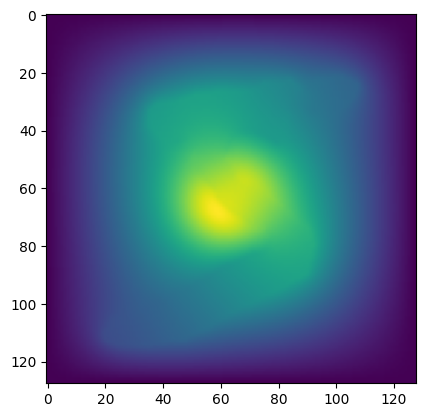

In [26]:
plt.imshow(u)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def _percentile_clip(img, lo=1, hi=99):
    vmin, vmax = np.percentile(img, [lo, hi])
    # protect against flat images
    if vmin == vmax:
        vmin, vmax = img.min(), img.max() if img.max() > img.min() else (0.0, 1.0)
    return dict(vmin=vmin, vmax=vmax)

def _maybe_contour_sdf(sdf, H, W, color="k", lw=1.2, label="SDF=0"):
    if sdf is None:
        return None
    xs = np.linspace(0, 1, W)
    ys = np.linspace(0, 1, H)
    # draw contour
    plt.contour(xs, ys, sdf, levels=[0], colors=color, linewidths=lw)
    # return a proxy handle for legend (works on all mpl versions)
    return Line2D([0], [0], color=color, lw=lw, label=label)

def plot_coefficient(a, sdf=None, title="Coefficient a(x)"):
    H, W = a.shape
    plt.figure(figsize=(5,4))
    plt.imshow(a, origin="lower", extent=[0,1,0,1], **_percentile_clip(a))
    plt.colorbar(label="a(x)")
    handle = _maybe_contour_sdf(sdf, H, W, color="k", lw=1.5, label="SDF=0")
    if handle is not None:
        plt.legend(handles=[handle], loc="upper right", frameon=True)
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()

def plot_solution(u, sdf=None, title="Solution u(x)"):
    H, W = u.shape
    plt.figure(figsize=(5,4))
    plt.imshow(u, origin="lower", extent=[0,1,0,1], **_percentile_clip(u))
    plt.colorbar(label="u")
    # iso-lines of u
    levels = np.linspace(u.min(), u.max(), 7)[1:-1] if u.max() > u.min() else []
    if len(levels):
        xs = np.linspace(0,1,W); ys = np.linspace(0,1,H)
        plt.contour(xs, ys, u, levels=levels, linewidths=0.8)
    handle = _maybe_contour_sdf(sdf, H, W, color="k", lw=1.2, label="SDF=0")
    if handle is not None:
        plt.legend(handles=[handle], loc="upper right", frameon=True)
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()

def plot_velocity(vx, vy, sdf=None, stride=6, title=r"Velocity $|\mathbf{v}|$ and quiver"):
    H, W = vx.shape
    speed = np.hypot(vx, vy)
    plt.figure(figsize=(5,4))
    plt.imshow(speed, origin="lower", extent=[0,1,0,1], **_percentile_clip(speed))
    plt.colorbar(label="|v|")
    xs = np.linspace(0,1,W); ys = np.linspace(0,1,H)
    X, Y = np.meshgrid(xs, ys)
    plt.quiver(X[::stride,::stride], Y[::stride,::stride],
               vx[::stride,::stride], vy[::stride,::stride],
               scale=None, width=0.002, alpha=0.85)
    handle = _maybe_contour_sdf(sdf, H, W, color="k", lw=1.2, label="SDF=0")
    if handle is not None:
        plt.legend(handles=[handle], loc="upper right", frameon=True)
    plt.title(title); plt.xlabel("x"); plt.ylabel("y")
    plt.tight_layout()

def plot_all(a, u, vx=None, vy=None, sdf=None):
    plot_coefficient(a, sdf=sdf, title="Coefficient a(x)")
    plot_solution(u, sdf=sdf, title="Solution u(x)")
    if vx is not None and vy is not None:
        plot_velocity(vx, vy, sdf=sdf, stride=6, title=r"Velocity $|\mathbf{v}|$ with quiver")


TypeError: float() argument must be a string or a real number, not 'tuple'

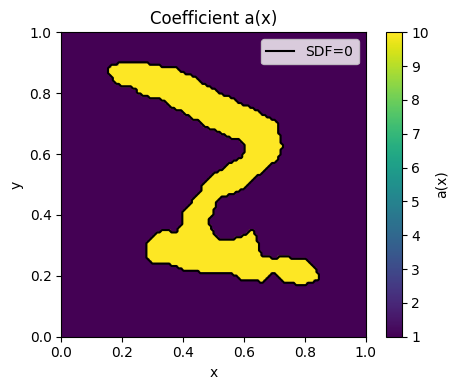

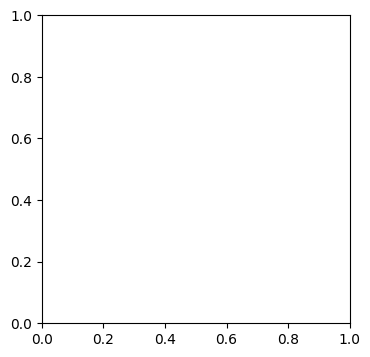

In [11]:
plot_all(a, u, vx=None, vy=None, sdf=sdf)   # or pass vx,vy if you computed them
plt.show()


In [27]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

# ---------- SDF -> coefficient a(x) ----------
def coeff_from_sdf_smooth(sdf, a_in=1e-3, a_out=1.0, alpha=40.0):
    """
    Smooth mapping so gradients w.r.t. sdf are well-behaved:
        inside (sdf<0) -> ~a_in, outside -> ~a_out
        a(x) = a_out + (a_in - a_out) * sigmoid(alpha * sdf)
    NOTE: sdf is NEGATIVE inside, so sigmoid(alpha*sdf) ~ 0 inside.
    """
    sdf = np.asarray(sdf, dtype=np.float64)
    sig = 1.0 / (1.0 + np.exp(-alpha * sdf))  # ~0 inside, ~1 outside
    a = a_out + (a_in - a_out) * (1.0 - sig)  # (1-sig) ~1 inside
    a = np.clip(a, min(a_in, a_out)*1e-6, max(a_in, a_out)*1e6)  # safety
    return a

# ---------- Dirichlet BC helpers & tokens ----------
def _as_vec(val, n):
    v = np.asarray(val, dtype=np.float64)
    if v.ndim == 0:
        return np.full(n, float(v))
    assert v.shape == (n,)
    return v

def make_bc_tokens(H, W, kind="left_right", strength=1.0, angle_deg=0.0, seed=None):
    """
    Return a (2,H,W) array encoding boundary conditions as 'image tokens'.
    Channel 0 = desired Dirichlet value on LEFT/RIGHT edges (broadcast inside by the model).
    Channel 1 = desired Dirichlet value on BOTTOM/TOP edges.
    These are *inputs* to the FNO; the PDE solver below also uses the explicit scalar/array BCs.
    """
    rng = np.random.default_rng(seed)
    bc_left = np.zeros(H); bc_right = np.zeros(H)
    bc_bottom = np.zeros(W); bc_top = np.zeros(W)

    if kind == "left_right":
        bc_left[:]  = strength
        bc_right[:] = 0.0
    elif kind == "right_left":
        bc_left[:]  = 0.0
        bc_right[:] = strength
    elif kind == "top_bottom":
        bc_top[:]    = strength
        bc_bottom[:] = 0.0
    elif kind == "bottom_top":
        bc_top[:]    = 0.0
        bc_bottom[:] = strength
    elif kind == "stripe_lr":
        # sinusoidal variation along y on left, right=0
        y = np.linspace(0, 1, H)
        bc_left  = strength * (0.5 + 0.5*np.sin(2*np.pi*(y - 0.25)))
        bc_right = np.zeros(H)
    elif kind == "random_electrodes":
        # K random "electrodes" on boundary with +strength, others 0
        K = rng.integers(2, 6)
        idxs = rng.choice(H, size=K, replace=False)
        bc_left[idxs] = strength
    else:
        raise ValueError(f"Unknown BC kind: {kind}")

    # Build simple 2-channel token image
    tok = np.zeros((2, H, W), dtype=np.float64)
    tok[0, :, 0]   = bc_left
    tok[0, :, -1]  = bc_right
    tok[1, 0, :]   = bc_bottom
    tok[1, -1, :]  = bc_top
    return tok, bc_left, bc_right, bc_bottom, bc_top

# ---------- Elliptic solver with general Dirichlet BCs ----------
def solve_elliptic_conductivity_dirichlet(a, f, *, 
                                          bc_left=0.0, bc_right=0.0, 
                                          bc_bottom=0.0, bc_top=0.0):
    """
    Solve -div(a grad u) = f on full HxW with Dirichlet values on outer boundary.
    bc_* can be scalars or length-H/length-W arrays.
    Discretization: 5-point FD with harmonic-mean face coefficients (jump-aware).
    """
    a = np.asarray(a, dtype=np.float64)
    f = np.asarray(f, dtype=np.float64)
    H, W = a.shape
    assert f.shape == (H, W)

    bc_left   = _as_vec(bc_left,   H)
    bc_right  = _as_vec(bc_right,  H)
    bc_bottom = _as_vec(bc_bottom, W)
    bc_top    = _as_vec(bc_top,    W)

    hx = 1.0 / (W - 1)
    hy = 1.0 / (H - 1)
    inv_hx2 = 1.0 / (hx*hx)
    inv_hy2 = 1.0 / (hy*hy)

    Ni, Nj = H-2, W-2
    N = Ni * Nj

    def idx(i, j):
        return (i-1)*Nj + (j-1)

    A = sparse.lil_matrix((N, N), dtype=np.float64)
    b = np.zeros(N, dtype=np.float64)

    eps = 1e-12
    for i in range(1, H-1):
        for j in range(1, W-1):
            k = idx(i, j)
            aC = a[i, j]
            aE = 2.0 * aC * a[i, j+1] / (aC + a[i, j+1] + eps)
            aW = 2.0 * aC * a[i, j-1] / (aC + a[i, j-1] + eps)
            aN = 2.0 * aC * a[i+1, j] / (aC + a[i+1, j] + eps)
            aS = 2.0 * aC * a[i-1, j] / (aC + a[i-1, j] + eps)

            diag = (aE + aW) * inv_hx2 + (aN + aS) * inv_hy2
            A[k, k] = diag

            # West
            if j-1 >= 1:
                A[k, idx(i, j-1)] = -aW * inv_hx2
            else:
                b[k] += aW * inv_hx2 * bc_left[i]
            # East
            if j+1 <= W-2:
                A[k, idx(i, j+1)] = -aE * inv_hx2
            else:
                b[k] += aE * inv_hx2 * bc_right[i]
            # South
            if i-1 >= 1:
                A[k, idx(i-1, j)] = -aS * inv_hy2
            else:
                b[k] += aS * inv_hy2 * bc_bottom[j]
            # North
            if i+1 <= H-2:
                A[k, idx(i+1, j)] = -aN * inv_hy2
            else:
                b[k] += aN * inv_hy2 * bc_top[j]

            b[k] += f[i, j]  # here f=0 for boundary-driven Darcy

    u_int = spsolve(A.tocsr(), b)

    u = np.zeros((H, W), dtype=np.float64)
    u[:, 0]   = bc_left
    u[:, -1]  = bc_right
    u[0, :]   = bc_bottom
    u[-1, :]  = bc_top
    u[1:-1, 1:-1] = u_int.reshape(Ni, Nj)
    return u

# ---------- Convenience: one-sample generator (ready for FNO) ----------
def make_sample_from_sdf(sdf,
                         a_in=1e-3, a_out=1.0, alpha=40.0,
                         bc_kind="left_right", bc_strength=1.0, seed=None,
                         include_phi_channel=True):
    """
    Returns:
      x_in  : (C,H,W) input channels for FNO  (C = 1 or 2 or 3)
              [a] or [a, phi] or [a, BC_tokens(2)]
      bc_tok: (2,H,W) BC token image (always returned; you can choose to concat it)
      u     : (H,W) solution
    """
    sdf = np.asarray(sdf, dtype=np.float64)
    H, W = sdf.shape
    a = coeff_from_sdf_smooth(sdf, a_in=a_in, a_out=a_out, alpha=alpha)

    # BC tokens for the NN + scalar/array BCs for the PDE solve
    bc_tok, bc_left, bc_right, bc_bottom, bc_top = make_bc_tokens(
        H, W, kind=bc_kind, strength=bc_strength, seed=seed
    )

    # No interior forcing for boundary-driven Darcy
    f = np.zeros_like(a)
    u = solve_elliptic_conductivity_dirichlet(
        a, f, bc_left=bc_left, bc_right=bc_right,
        bc_bottom=bc_bottom, bc_top=bc_top
    )

    # Pack inputs for FNO: choose how many channels you want
    inputs = [a[np.newaxis, ...]]  # (1,H,W)
    if include_phi_channel:
        inputs.append(sdf[np.newaxis, ...])   # add SDF (1,H,W)
    # Always good to pass BC tokens too (model must "know" which BC produced u)
    inputs.append(bc_tok)  # (2,H,W)

    x_in = np.concatenate(inputs, axis=0)  # (C,H,W)
    return x_in, bc_tok, u

# ---------- Optional: quick plotting ----------
def quick_show(a=None, u=None, sdf=None, title_suffix=""):
    import matplotlib.pyplot as plt
    def im(ax, img, ttl):
        if img is None: return
        m = ax.imshow(img, origin="lower", extent=[0,1,0,1])
        plt.colorbar(m, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title(ttl)
    ncols = sum(x is not None for x in [a, u, sdf])
    fig, axes = plt.subplots(1, ncols, figsize=(4.5*ncols, 4))
    if ncols == 1: axes = [axes]
    idx = 0
    if a is not None:
        im(axes[idx], a, f"a(x) {title_suffix}"); idx += 1
    if u is not None:
        im(axes[idx], u, f"u(x) {title_suffix}"); idx += 1
    if sdf is not None:
        im(axes[idx], sdf, f"SDF {title_suffix}")
    plt.tight_layout()


In [28]:
# sdf: (128,128) negative inside the digit
x_in, bc_tok, u = make_sample_from_sdf(
    sdf,
    a_in=1e-3, a_out=1.0, alpha=40.0,    # insulating digit with smooth interface
    bc_kind="left_right", bc_strength=1.0,
    seed=0,
    include_phi_channel=True             # input channels = [a, phi, BC_tokens(2)] -> total C=4
)

# x_in has shape (C,128,128). For FNO you typically pass (B,C,H,W) batched.
# Example: torch.from_numpy(x_in).unsqueeze(0)

# Optional quick look:
# quick_show(a=x_in[0], u=u, sdf=sdf)


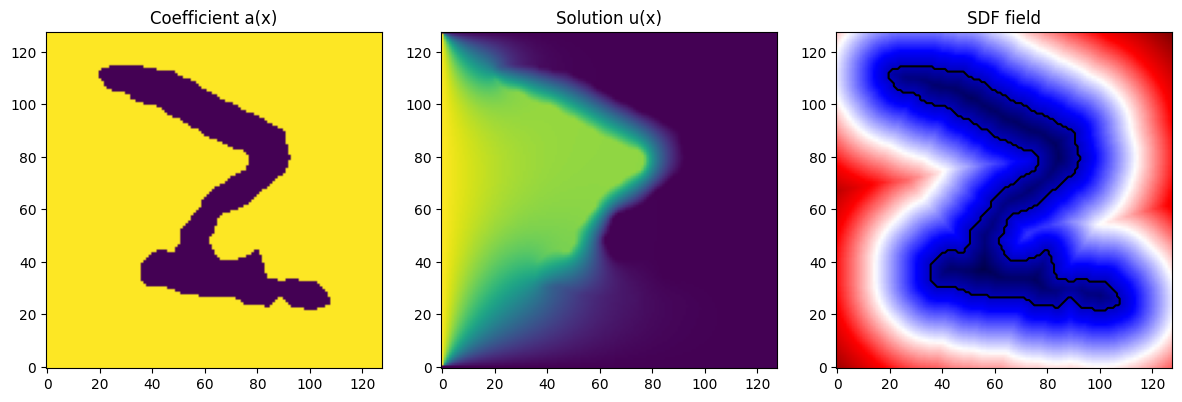

In [29]:
import matplotlib.pyplot as plt

# assume you already have: sdf, x_in, u  from make_sample_from_sdf(...)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Coefficient a(x) is the first channel of x_in
axes[0].imshow(x_in[0], origin="lower", cmap="viridis")
axes[0].set_title("Coefficient a(x)")

# Solution u(x)
axes[1].imshow(u, origin="lower", cmap="viridis")
axes[1].set_title("Solution u(x)")

# Raw SDF (negative inside digit)
axes[2].imshow(sdf, origin="lower", cmap="seismic")
axes[2].contour(sdf, levels=[0], colors="k")  # outline the digit
axes[2].set_title("SDF field")

plt.tight_layout()
plt.show()


In [30]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

# --- helpers for derivatives on the unit square grid ---
def central_grad_xy(F):
    H, W = F.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    Fx = np.zeros_like(F); Fy = np.zeros_like(F)
    Fx[:,1:-1] = (F[:,2:] - F[:,:-2])/(2*hx)
    Fy[1:-1,:] = (F[2:,:] - F[:-2,:])/(2*hy)
    return Fx, Fy

def laplacian_5pt(A):
    H, W = A.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    L = np.zeros_like(A)
    L[1:-1,1:-1] = (
        (A[1:-1,2:] - 2*A[1:-1,1:-1] + A[1:-1,:-2])/(hx*hx)
      + (A[2:,1:-1] - 2*A[1:-1,1:-1] + A[:-2,1:-1])/(hy*hy)
    )
    return L

# --- your forward solver (already defined earlier) ---
# solve_elliptic_conductivity_dirichlet(a, f, bc_left, bc_right, bc_bottom, bc_top)
# (Keep using the same function from your previous cell.)

# --- objective, adjoint, gradient ---
def forward_solve(a, f, bc_left, bc_right, bc_bottom, bc_top):
    return solve_elliptic_conductivity_dirichlet(
        a, f, bc_left=bc_left, bc_right=bc_right, bc_bottom=bc_bottom, bc_top=bc_top
    )

def adjoint_solve(a, u, u_obs, bc_left, bc_right, bc_bottom, bc_top):
    """
    Adjoint PDE:  -div(a grad p) = (u - u_obs),  with homogeneous Dirichlet on the boundary
    (same boundary geometry as forward; RHS is the data misfit).
    """
    rhs = (u - u_obs)
    # zero Dirichlet on the boundary by passing zeros as BCs:
    return solve_elliptic_conductivity_dirichlet(
        a, rhs, bc_left=0.0, bc_right=0.0, bc_bottom=0.0, bc_top=0.0
    )

def objective(a, u_obs, f, bc_left, bc_right, bc_bottom, bc_top, gamma):
    u = forward_solve(a, f, bc_left, bc_right, bc_bottom, bc_top)
    mis = 0.5*np.mean((u - u_obs)**2)
    reg = 0.5*gamma*np.mean( (np.gradient(a, axis=0)[0] if False else 0) ) # placeholder to avoid confusion
    # Use Laplacian-based reg energy (∥∇a∥²) via Parseval equivalence:
    ax, ay = central_grad_xy(a)
    reg = 0.5*gamma*np.mean(ax*ax + ay*ay)
    return mis + reg, u

def gradient_wrt_a(a, u, u_obs, gamma, bc_left, bc_right, bc_bottom, bc_top):
    """
    ∂J/∂a = - (∇u · ∇p) + gamma * (-Δ a)
    where p solves the adjoint.
    """
    p = adjoint_solve(a, u, u_obs, bc_left, bc_right, bc_bottom, bc_top)
    ux, uy = central_grad_xy(u)
    px, py = central_grad_xy(p)
    data_term = -(ux*px + uy*py)
    reg_term = -gamma * laplacian_5pt(a)
    g = data_term + reg_term
    return g, p

def project_box(a, amin, amax):
    return np.clip(a, amin, amax)

# --- main inversion loop (projected gradient with backtracking) ---
def invert_conductivity_from_u(
    u_obs,                      # measured solution (H,W)
    a_init,                     # initial guess (H,W)
    f,                          # same forcing used to generate u_obs (often zeros for boundary-driven case)
    bc_left, bc_right, bc_bottom, bc_top,  # same Dirichlet BCs as in forward run
    gamma=1e-2,                 # smoothness weight
    amin=1e-3, amax=10.0,       # positivity/box constraints
    step0=1e-1,                 # initial step size
    max_iter=50,                # iterations
    verbose=True
):
    a = project_box(a_init.copy(), amin, amax)
    J, u = objective(a, u_obs, f, bc_left, bc_right, bc_bottom, bc_top, gamma)
    if verbose: print(f"iter 0: J={J:.6e}")

    step = step0
    for it in range(1, max_iter+1):
        g, p = gradient_wrt_a(a, u, u_obs, gamma, bc_left, bc_right, bc_bottom, bc_top)
        # backtracking line-search
        ok = False
        for _ in range(10):
            a_try = project_box(a - step*g, amin, amax)
            J_try, u_try = objective(a_try, u_obs, f, bc_left, bc_right, bc_bottom, bc_top, gamma)
            if J_try <= J - 1e-4*step*np.mean(g*g):  # sufficient decrease
                ok = True
                break
            step *= 0.5
        if not ok:
            # accept small progress anyway
            a_try, u_try, J_try = a - step*g, u, J
        a, u, J = a_try, u_try, J_try
        if verbose and it % 5 == 0:
            print(f"iter {it}: J={J:.6e}, step={step:.2e}")
    return a, u


iter 0: J=1.860365e-02
iter 5: J=1.843146e-02, step=6.25e-03
iter 10: J=1.840693e-02, step=3.13e-03
iter 15: J=1.839117e-02, step=3.13e-03
iter 20: J=1.837621e-02, step=3.13e-03
iter 25: J=1.836166e-02, step=3.13e-03
iter 30: J=1.834749e-02, step=3.13e-03
iter 35: J=1.833369e-02, step=3.13e-03
iter 40: J=1.832025e-02, step=3.13e-03


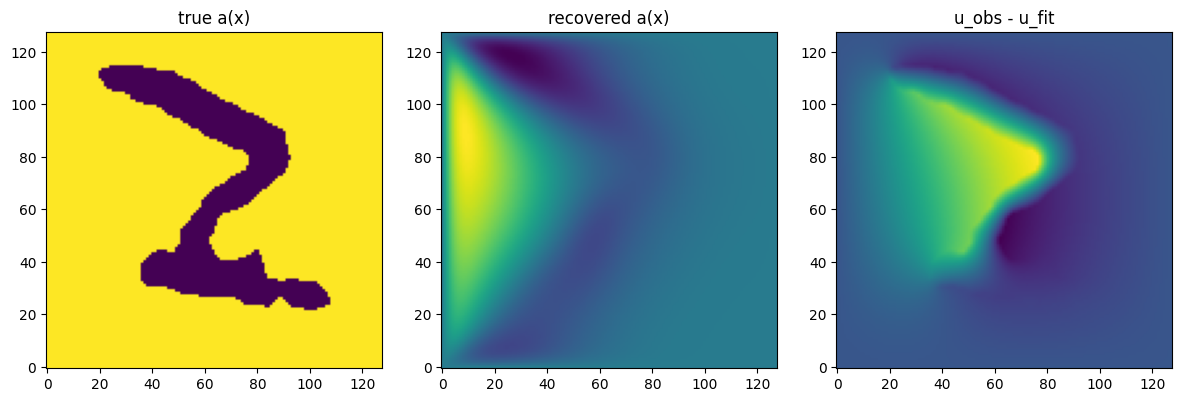

In [31]:
# 1) make a ground-truth sample (your usual pipeline)
# sdf, a_true, BC tokens and arrays, u_obs = forward solution
x_in, bc_tok, u_obs = make_sample_from_sdf(
    sdf, a_in=1e-3, a_out=1.0, alpha=40.0,
    bc_kind="left_right", bc_strength=1.0, seed=0, include_phi_channel=True
)
a_true = x_in[0]           # our generator returns a as channel 0
H, W = u_obs.shape
f = np.zeros((H,W))        # boundary-driven: no interior source

# Extract the BC arrays that were used to generate u_obs
_, bc_left, bc_right, bc_bottom, bc_top = make_bc_tokens(H, W, kind="left_right", strength=1.0, seed=0)

# 2) pick an initial guess for a(x) (e.g., uniform)
a0 = np.ones_like(a_true)

# 3) invert
a_rec, u_fit = invert_conductivity_from_u(
    u_obs, a0, f, bc_left, bc_right, bc_bottom, bc_top,
    gamma=5e-3, amin=1e-4, amax=5.0, step0=1e-1, max_iter=40, verbose=True
)

# 4) quick plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a_true, origin="lower"); ax[0].set_title("true a(x)")
ax[1].imshow(a_rec,  origin="lower"); ax[1].set_title("recovered a(x)")
ax[2].imshow(u_obs - u_fit, origin="lower"); ax[2].set_title("u_obs - u_fit")
plt.tight_layout(); plt.show()


In [32]:
import numpy as np
from scipy.sparse.linalg import spsolve  # already imported earlier

def central_grad_xy(F):
    H, W = F.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    Fx = np.zeros_like(F); Fy = np.zeros_like(F)
    Fx[:,1:-1] = (F[:,2:] - F[:,:-2])/(2*hx)
    Fy[1:-1,:] = (F[2:,:] - F[:-2,:])/(2*hy)
    return Fx, Fy

def laplacian_5pt(A):
    H, W = A.shape
    hx = 1.0/(W-1); hy = 1.0/(H-1)
    L = np.zeros_like(A)
    L[1:-1,1:-1] = (
        (A[1:-1,2:] - 2*A[1:-1,1:-1] + A[1:-1,:-2])/(hx*hx)
      + (A[2:,1:-1] - 2*A[1:-1,1:-1] + A[:-2,1:-1])/(hy*hy)
    )
    return L


In [33]:
def make_observations_multiBC(a_true, bc_kinds, strength=1.0, seeds=None):
    """
    Returns:
      u_obs_list: list of (H,W) solutions for each BC kind
      bc_list   : list of (bc_left, bc_right, bc_bottom, bc_top) arrays
    """
    H, W = a_true.shape
    if seeds is None: seeds = [None]*len(bc_kinds)
    f0 = np.zeros((H, W))
    u_obs_list, bc_list = [], []
    for kind, seed in zip(bc_kinds, seeds):
        _, bc_left, bc_right, bc_bottom, bc_top = make_bc_tokens(
            H, W, kind=kind, strength=strength, seed=seed
        )
        u = solve_elliptic_conductivity_dirichlet(
            a_true, f0, bc_left=bc_left, bc_right=bc_right,
            bc_bottom=bc_bottom, bc_top=bc_top
        )
        u_obs_list.append(u)
        bc_list.append((bc_left, bc_right, bc_bottom, bc_top))
    return u_obs_list, bc_list


In [34]:
def forward_solve(a, f, bc_tuple):
    bc_left, bc_right, bc_bottom, bc_top = bc_tuple
    return solve_elliptic_conductivity_dirichlet(
        a, f, bc_left=bc_left, bc_right=bc_right, bc_bottom=bc_bottom, bc_top=bc_top
    )

def adjoint_solve(a, resid):
    # Homogeneous Dirichlet on the box for adjoint
    H, W = a.shape
    zerosL = np.zeros(H); zerosR = np.zeros(H); zerosB = np.zeros(W); zerosT = np.zeros(W)
    return solve_elliptic_conductivity_dirichlet(
        a, resid, bc_left=zerosL, bc_right=zerosR, bc_bottom=zerosB, bc_top=zerosT
    )

def project_box(a, amin, amax):
    return np.clip(a, amin, amax)

def invert_conductivity_multiBC(
    u_obs_list, bc_list,           # K observations and their BCs
    a_init,                        # initial guess (H,W)
    gamma=5e-3,                    # smoothness weight
    amin=1e-4, amax=5.0,           # box constraints for positivity/boundedness
    step0=1e-1, max_iter=60,       # optimizer settings
    verbose=True
):
    K = len(u_obs_list)
    H, W = a_init.shape
    f0 = np.zeros((H, W))
    a = project_box(a_init.copy(), amin, amax)

    # initial forward solves
    u_list = [forward_solve(a, f0, bc) for bc in bc_list]
    mis = sum(0.5*np.mean((u - u_obs)**2) for u, u_obs in zip(u_list, u_obs_list))/K
    ax, ay = central_grad_xy(a)
    reg = 0.5*gamma*np.mean(ax*ax + ay*ay)
    J = mis + reg
    if verbose: print(f"iter 0: J={J:.6e}  mis={mis:.6e}  reg={reg:.6e}")

    step = step0
    for it in range(1, max_iter+1):
        # gradient accumulation over experiments
        data_grad = np.zeros_like(a)
        for u, u_obs, bc in zip(u_list, u_obs_list, bc_list):
            resid = u - u_obs
            p = adjoint_solve(a, resid)
            ux, uy = central_grad_xy(u)
            px, py = central_grad_xy(p)
            data_grad += -(ux*px + uy*py)
        data_grad /= K
        reg_grad = -gamma * laplacian_5pt(a)
        g = data_grad + reg_grad

        # backtracking line search
        ok = False
        for _ in range(10):
            a_try = project_box(a - step*g, amin, amax)
            u_try_list = [forward_solve(a_try, f0, bc) for bc in bc_list]
            mis_try = sum(0.5*np.mean((u - u_obs)**2) for u, u_obs in zip(u_try_list, u_obs_list))/K
            ax, ay = central_grad_xy(a_try)
            reg_try = 0.5*gamma*np.mean(ax*ax + ay*ay)
            J_try = mis_try + reg_try
            # Armijo
            if J_try <= J - 1e-4*step*np.mean(g*g):
                ok = True
                break
            step *= 0.5

        if ok:
            a, u_list, J, mis, reg = a_try, u_try_list, J_try, mis_try, reg_try
        # (else keep previous a and shrink step already)

        if verbose and (it % 5 == 0 or it == max_iter):
            print(f"iter {it}: J={J:.6e} mis={mis:.6e} reg={reg:.6e} step={step:.2e}")

    return a, u_list


iter 0: J=1.076753e-02  mis=1.076753e-02  reg=0.000000e+00
iter 5: J=1.069349e-02 mis=1.068890e-02 reg=4.588588e-06 step=1.25e-02
iter 10: J=1.068021e-02 mis=1.067368e-02 reg=6.525716e-06 step=6.25e-03
iter 15: J=1.067240e-02 mis=1.066539e-02 reg=7.011732e-06 step=6.25e-03
iter 20: J=1.066522e-02 mis=1.065723e-02 reg=7.981203e-06 step=6.25e-03
iter 25: J=1.065820e-02 mis=1.064921e-02 reg=8.991859e-06 step=6.25e-03
iter 30: J=1.065135e-02 mis=1.064131e-02 reg=1.004071e-05 step=6.25e-03
iter 35: J=1.064465e-02 mis=1.063352e-02 reg=1.112516e-05 step=6.25e-03
iter 40: J=1.063810e-02 mis=1.062585e-02 reg=1.224284e-05 step=6.25e-03
iter 45: J=1.063169e-02 mis=1.061830e-02 reg=1.339162e-05 step=6.25e-03
iter 50: J=1.062541e-02 mis=1.061084e-02 reg=1.456953e-05 step=6.25e-03
iter 55: J=1.061927e-02 mis=1.060349e-02 reg=1.577478e-05 step=6.25e-03
iter 60: J=1.061325e-02 mis=1.059624e-02 reg=1.700572e-05 step=6.25e-03


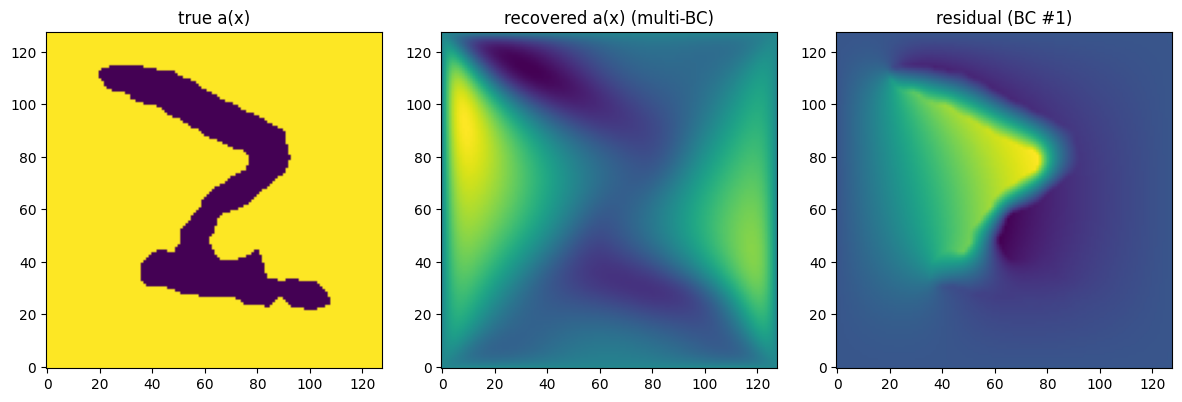

In [35]:
# Ground truth conductivity (from your SDF pipeline)
a_true = x_in[0]                   # first channel if you used make_sample_from_sdf(...)
H, W = a_true.shape

# Choose multiple BC patterns (orthogonal ones help most)
bc_kinds = ["left_right", "right_left", "top_bottom", "bottom_top"]
u_obs_list, bc_list = make_observations_multiBC(a_true, bc_kinds, strength=1.0, seeds=[0,1,2,3])

# Initial guess
a0 = np.ones_like(a_true)

# Invert jointly
a_rec, u_fit_list = invert_conductivity_multiBC(
    u_obs_list, bc_list, a0,
    gamma=2e-3, amin=1e-4, amax=5.0, step0=1e-1, max_iter=60, verbose=True
)

# Quick plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(a_true, origin="lower"); ax[0].set_title("true a(x)")
ax[1].imshow(a_rec,  origin="lower"); ax[1].set_title("recovered a(x) (multi-BC)")
# show residual for the first BC
ax[2].imshow(u_obs_list[0] - u_fit_list[0], origin="lower"); ax[2].set_title("residual (BC #1)")
plt.tight_layout(); plt.show()


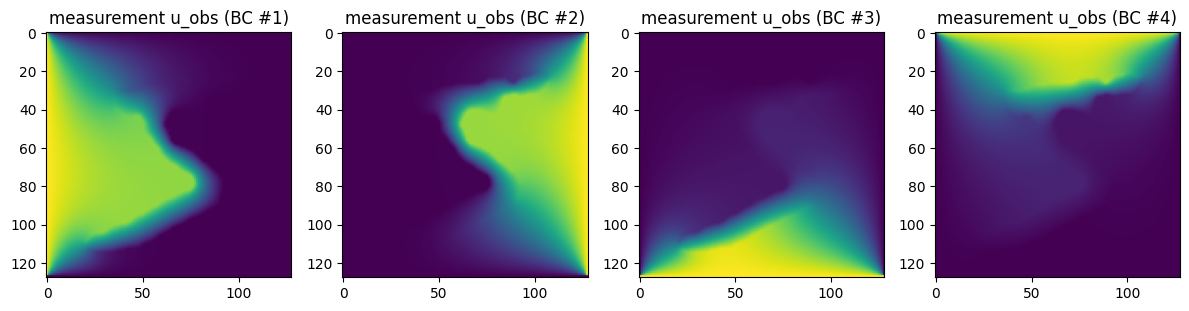

In [46]:
fig, ax = plt.subplots(1,4, figsize=(12,4))
ax[0].imshow(u_obs_list[0]); ax[0].set_title("measurement u_obs (BC #1)")
ax[1].imshow(u_obs_list[1]); ax[1].set_title("measurement u_obs (BC #2)")
ax[2].imshow(u_obs_list[2]); ax[2].set_title("measurement u_obs (BC #3)")
ax[3].imshow(u_obs_list[3]); ax[3].set_title("measurement u_obs (BC #4)")
plt.tight_layout(); plt.show()


# Forward and Inverse Problem Formulation

We consider the elliptic conductivity equation (Darcy flow equation) on the unit square domain  

$$
\Omega = [0,1]^2,
$$

with boundary $\partial \Omega$.

---

## Forward problem

Given a positive conductivity (permeability) field $a(x)$, a source term $f(x)$, and boundary conditions $g(x)$, 
the state variable $u(x)$ solves

$$
\begin{aligned}
- \nabla \cdot \big( a(x)\, \nabla u(x) \big) &= f(x), 
&& x \in \Omega, \\
u(x) &= g(x), 
&& x \in \partial \Omega .
\end{aligned}
$$

- $a(x) > 0$: conductivity field  
- $u(x)$: scalar solution (pressure / potential)  
- $f(x)$: source term (often $f \equiv 0$ or Gaussian bump)  
- $g(x)$: boundary conditions (e.g. left–right, top–bottom Dirichlet profiles)  

The forward operator is

$$
u = \mathcal{F}[a; f, g].
$$

---

## Observations

We assume we can measure the solution $u(x)$ under several distinct boundary conditions.  

Let $\{ g^{(k)} \}_{k=1}^K$ denote $K$ boundary conditions.  
The observed data are

$$
u_{\text{obs}}^{(k)}(x) \;\approx\; \mathcal{F}[a_{\text{true}}; f, g^{(k)}], 
\qquad k=1,\dots,K,
$$

where $a_{\text{true}}(x)$ is the unknown ground-truth coefficient.

---

## Inverse problem

We want to recover $a(x)$ from observations $\{u_{\text{obs}}^{(k)}\}_{k=1}^K$.  

Formulate as PDE-constrained optimization:

$$
\min_{a(x) \,\in\, \mathcal{A}} 
\; J[a] 
= \frac{1}{K} \sum_{k=1}^K 
\frac{1}{2} \int_\Omega 
\Big| \, u^{(k)}(x; a) - u_{\text{obs}}^{(k)}(x) \,\Big|^2 \, dx
\;+\; \frac{\gamma}{2} \int_\Omega |\nabla a(x)|^2 \, dx,
$$

subject to

$$
- \nabla \cdot \big( a(x)\, \nabla u^{(k)}(x; a) \big) = f(x), 
\quad u^{(k)}|_{\partial \Omega} = g^{(k)}, 
\qquad k = 1,\dots,K.
$$

- First term = **data misfit** (ensures predictions match observations)  
- Second term = **Tikhonov regularization** on $a(x)$, weighted by $\gamma > 0$  

---

## Optimization scheme

1. Start from initial guess $a^0(x)$.  
2. For iteration $n = 0,1,2,\dots$:  
   - Solve forward PDEs for $u^{(k)}(x; a^n)$.  
   - Compute gradient $\frac{\partial J}{\partial a}(x)$ (via adjoint).  
   - Update:

   $$
   a^{n+1}(x) 
   = \Pi_{[a_{\min}, a_{\max}]}
   \left( a^n(x) - \eta \, \frac{\partial J}{\partial a}(x) \right),
   $$

   where $\eta$ = step size, and $\Pi$ = projection onto bounds.  

---

## Summary

- **Ground truth:** $a_{\text{true}}(x)$, generated from SDF field of digit  
- **Measurements:** $u_{\text{obs}}^{(k)}$, from forward PDE with $a_{\text{true}}$  
- **Forward predictions:** $u^{(k)}(x; a)$, solved during inversion  
- **Recovered coefficient:** $a_{\text{rec}}(x)$, minimizer of $J[a]$  

